In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from palettable.colorbrewer.sequential import GnBu_9

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46073,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:40003,Total threads: 4
Dashboard: /proxy/37531/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:40391,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')
mask = mask['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu']
hu = hu.sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90,-50.1,.1))), 1, np.nan)
land_ice_mask = land_ice_mask.interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, 
                                     land_ice_mask['lon'] + 360, 
                                     land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon':'_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj':sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj':'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_lin = xr.open_dataset('../data/smooth_div_line.nc')
div_lin = div_lin['__xarray_dataarray_variable__']

Load reanalysis and CMIP6 multimodel mean

In [4]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas']
    uas[k] = uas[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas']
    vas[k] = vas[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl']
    psl[k] = psl[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')

In [5]:
wsp = {}
for k in keys:
    wsp[k] = np.sqrt(uas[k]**2 + vas[k]**2)

In [6]:
from palettable.scientific.sequential import Bilbao_6

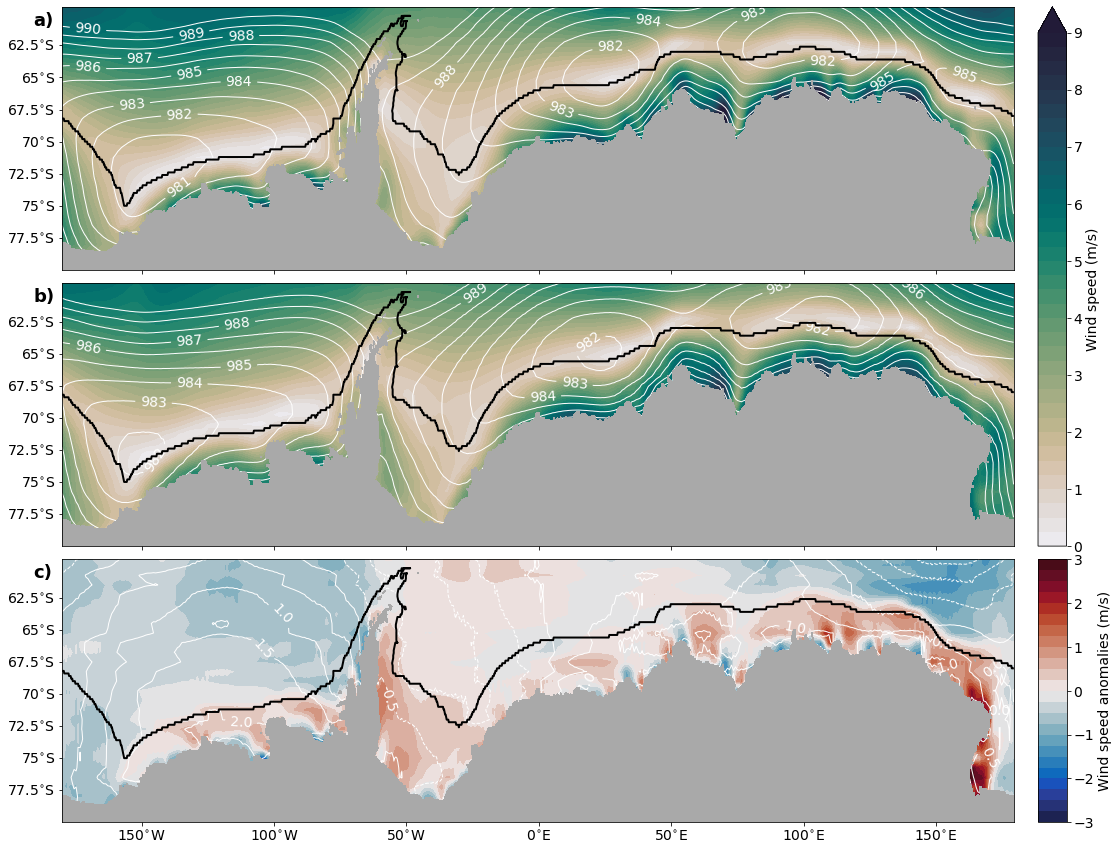

In [8]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 15))
gr = gs.GridSpec(3, 2, figure = fig, width_ratios = [1, .03], 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]), fig.add_subplot(gr[:2,1]), 
       fig.add_subplot(gr[2,1])]
for ax, label in zip(axs[:-2], ['a)', 'b)', 'c)']):
    ax.text(-0.03, .93, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)
    
# Reanalysis
k = 'reanalysis'
c1 = axs[0].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k], 
                    levels = np.arange(0, 9.25, .25), extend = 'max',
                    cmap = cmocean.cm.rain, zorder = 0)
cbar = fig.colorbar(c1, cax = axs[-2])
cbar.set_label('Wind speed (m/s)')
c = axs[0].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100,
                   levels = np.arange(950, 991, 1), colors = ['white'], 
                   linewidths = [1], zorder = 1)
axs[0].clabel(c, c.levels, inline=True, fmt='%1.0f', fontsize=14, zorder = 1)
# CMIP6
k = 'cmip6'
c = axs[1].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k], 
                    levels = np.arange(0, 9.25, .25), extend = 'max',
                    cmap = cmocean.cm.rain, zorder = 0)
c = axs[1].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100,
                   levels = np.arange(950, 991, 1), colors = ['white'], 
                   linewidths = [1], zorder = 1)
axs[1].clabel(c, c.levels, inline = True, fmt='%1.0f', fontsize=14, zorder = 1)
# CMIP6 anomalies
c = axs[2].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k]-wsp['reanalysis'], 
                    levels = np.arange(-3, 3.25, .25), 
                    cmap = cmocean.cm.balance, zorder = 0)
cbar = fig.colorbar(c, cax = axs[-1])
cbar.set_ticks(np.arange(-3, 4, 1))
cbar.set_label('Wind speed anomalies (m/s)')
c = axs[2].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100-psl['reanalysis']/100,
                   levels = np.arange(-2.5, 2.5, .5), colors = ['white'], 
                   linewidths = [1], zorder = 1)
axs[2].clabel(c, c.levels, inline = True, fmt='%1.1f', fontsize = 14, zorder = 1)

plt.savefig('../results/v6/fig1.jpg', bbox_inches = 'tight', dpi = 800)

# Supplementary

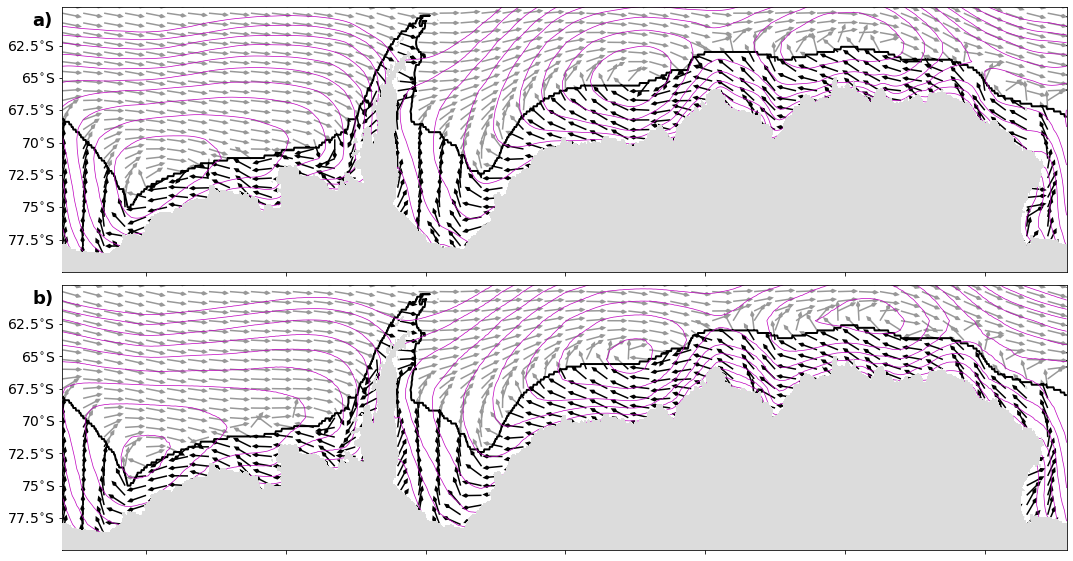

In [50]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 10))
gr = gs.GridSpec(2, 1, figure = fig, 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       ]
for ax, label in zip(axs, ['a)', 'b)']):
    ax.text(-0.03, .93, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'gainsboro', linewidths = 0.5, 
                zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), 
                  vmin = 1, vmax = 1.1, cmap = 'binary', alpha = 0.6, 
                  zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)
    
# Reanalysis
k = 'reanalysis'
#c = axs[0].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k], 
#                    levels = np.arange(0, 8.5, .5), 
#                    cmap = GnBu_9.mpl_colormap, zorder = 0)
#fig.colorbar(c, cax = axs[-1]).set_label('Wind speed [m/s]')
c = axs[0].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100,
                   levels = np.arange(900, 991, 1), colors = ['m'], 
                   linewidths = [0.7], zorder = 2)
axs[0].quiver(uas[k]['lon'][::10].values, uas[k]['lat'][::1].values, 
              (uas[k]/wsp[k])[::1,::10].values, (vas[k]/wsp[k])[::1,::10].values, 
              scale = 50, width = 0.0015, headlength = 3, zorder = 1)
# CMIP6
k = 'cmip6'
#c = axs[1].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k], 
#                    levels = np.arange(0, 8.5, .5), 
#                    cmap = GnBu_9.mpl_colormap, zorder = 0)
c = axs[1].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100,
                   levels = np.arange(900, 991, 1), colors = ['m'], 
                   linewidths = [0.7], zorder = 2)
axs[1].quiver(uas[k]['lon'][::10].values, uas[k]['lat'][::1].values, 
              (uas[k]/wsp[k])[::1,::10].values, (vas[k]/wsp[k])[::1,::10].values, 
              scale = 50, width = 0.0015, headlength = 3, zorder = 1)

plt.savefig('../results/v6/figsup1.jpg', bbox_inches = 'tight')

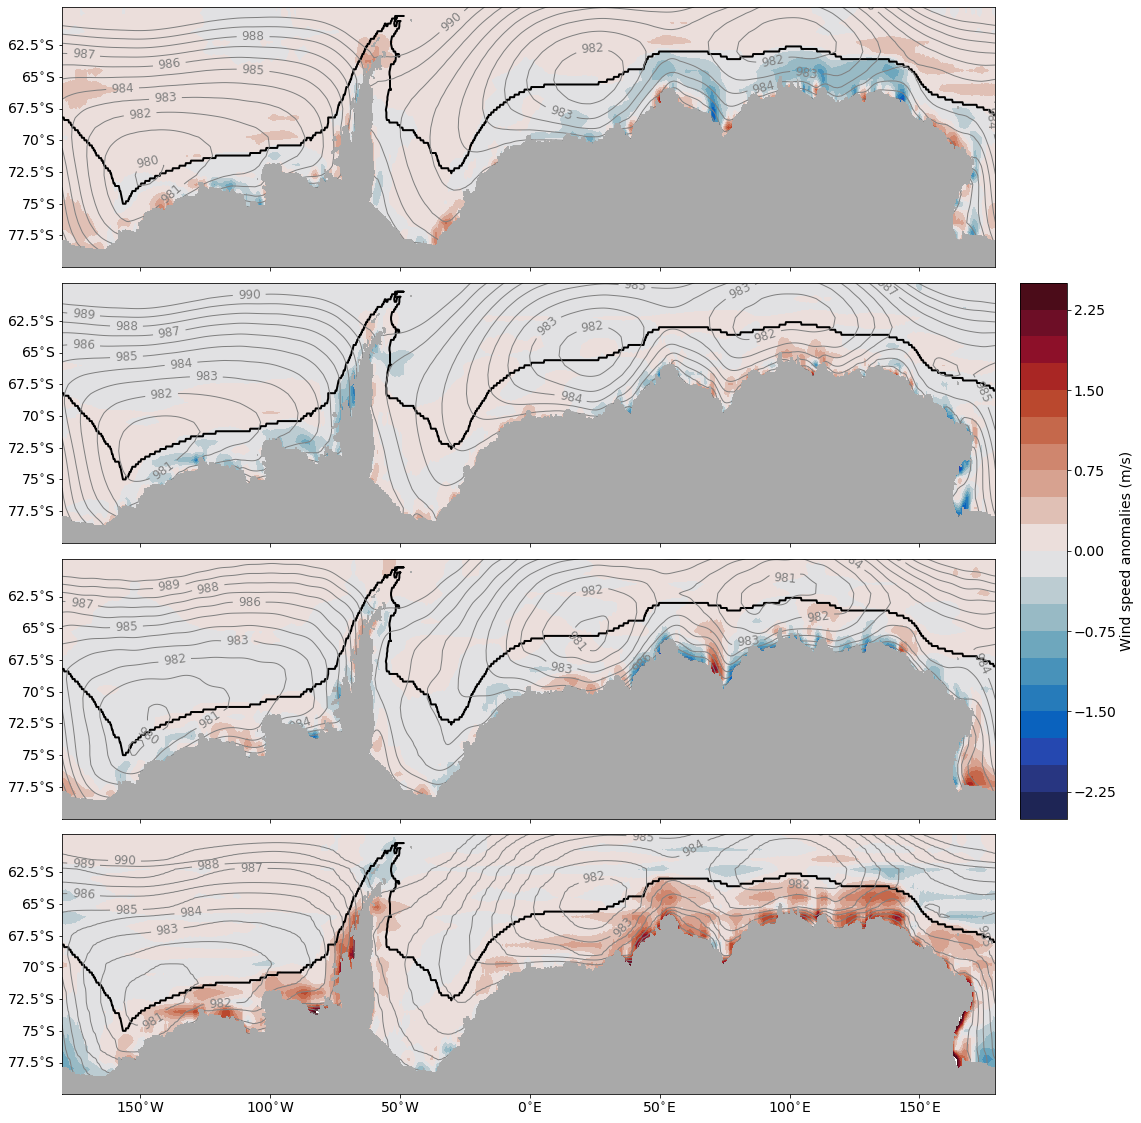

In [11]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.05], 
                 hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]), fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
for ax, label in zip(axs[:-1], ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']):
    #ax.text(0.03, .93, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                linewidths = 0.5, zorder = 3)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)

    n = 0
for k in keys[:-2]:
    cf = axs[n].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k]-wsp['reanalysis'],
                        levels = np.arange(-2.5, 2.75, .25), cmap = cmocean.cm.balance)
    cc = axs[n].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100, levels = np.arange(900, 991, 1),
                        linewidths = [1], colors = ['grey'], zorder = 2)
    axs[n].clabel(cc, cc.levels, inline = True, fmt='%1.0f', fontsize=12, zorder = 2)
    n += 1
    
fig.colorbar(cf, cax = axs[-1]).set_label('Wind speed anomalies (m/s)')

plt.savefig('../results/v6/figsup2.jpg', bbox_inches = 'tight', dpi = 600)

Load CMIP6 individual models

In [7]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
path_psl = glob.glob('../data/cmip6-regridded/psl_hist*')
uas_cmip = {}; vas_cmip = {}; psl_cmip = {}
for i in range(len(path_uas)):
    n = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[n] = xr.open_dataset(path_uas[i])['uas']
    uas_cmip[n] = uas_cmip[n].sel(time = slice('1979-01-01', '2015-01-01'))
    uas_cmip[n] = uas_cmip[n].mean('time')
    
    n = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[n] = xr.open_dataset(path_vas[i])['vas']
    vas_cmip[n] = vas_cmip[n].sel(time = slice('1979-01-01', '2015-01-01'))
    vas_cmip[n] = vas_cmip[n].mean('time')
    
    n = path_psl[i].split('/')[-1].split('_')[-1].split('.')[0]
    psl_cmip[n] = xr.open_dataset(path_psl[i])['psl']
    psl_cmip[n] = psl_cmip[n].sel(time = slice('1979-01-01', '2015-01-01'))
    psl_cmip[n] = psl_cmip[n].mean('time')
model_keys = list(uas_cmip.keys())

In [8]:
wsp_cmip = {}
for k in model_keys:
    wsp_cmip[k] = np.sqrt(uas_cmip[k]**2+vas_cmip[k]**2)

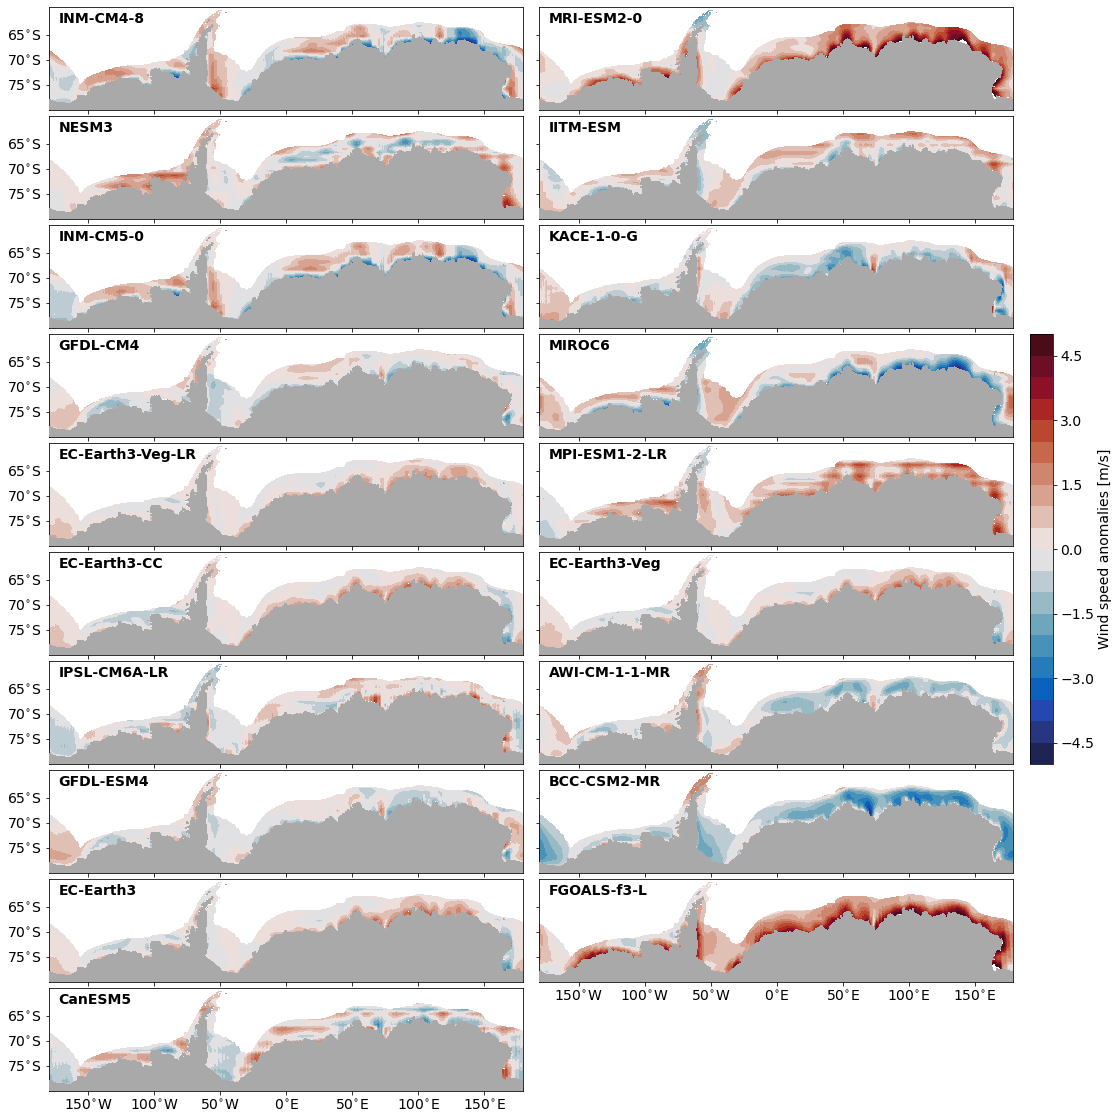

In [9]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 40))
gr = gs.GridSpec(20, 3, figure = fig, width_ratios = [1,1,.05], 
                 hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]), fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]), fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]), fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]), fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0]), fig.add_subplot(gr[3:7,2])]
for ax, label in zip(axs[:-1], model_keys):
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-75, -60,5))
    if ax in [axs[0], axs[2], axs[4], axs[6], axs[8], axs[10], 
              axs[12], axs[14], axs[16], axs[18]]:
        ax.set_yticklabels(['75$^{\circ}$S', '70$^{\circ}$S', '65$^{\circ}$S'])
    else:
        ax.set_yticklabels([])
    if ax in axs[:2]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E', '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', 
                linewidths = 0.5, 
                zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), 
                  vmin = 1, vmax = 1.1, 
                  cmap = 'binary', 
                  zorder = 2)
    
n = 0
for k in model_keys:
    ax.text(0.02, .85, k, transform = axs[n].transAxes, size = 14, weight = 'bold')
    cf = axs[n].contourf(wsp_cmip[k]['lon'], wsp_cmip[k]['lat'], wsp_cmip[k]-wsp['cmip6'], 
                        levels = np.arange(-5, 5.5, .5), 
                        cmap = cmocean.cm.balance)
    #cc = axs[n].contour(psl_cmip[k]['lon'], psl_cmip[k]['lat'], psl_cmip[k]/100, 
    #                    levels = np.arange(920, 1020, 5),
    #                    cmap = cmocean.cm.thermal, linewidths = [0.7], 
    #                    zorder = 4)
    #axs[n].clabel(cc, cc.levels, inline = True, fmt='%1.0f', fontsize=10)
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Wind speed anomalies [m/s]')
plt.savefig('../results/v6/figsup3.jpg', bbox_inches = 'tight', dpi = 600)

Do vertical levels vs. model bias

In [13]:
ver_levs = xr.DataArray([95, 45, 49, 91, 91, 91, 62, 32, 33, 49, 64, 21, 73, 79, 85, 81, 47, 80, 47], dims = 'model', coords = {'model':np.sort(model_keys)})
ver_levs_re = xr.DataArray([64, 60, 137, 60], dims = 'model', coords = {'model':['CFSR', 'ERA-Interim', 'ERA5', 'JRA55']})

In [28]:
vl = xr.concat([ver_levs, ver_levs_re], dim = 'model')
vl = vl.sortby(vl)

In [9]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai']))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [10]:
wsp_ave = {}
for k in keys:
    wsp_ave[k] = (wsp[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    wsp_ave[k] = (wsp_cmip[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [11]:
wsp_bias = wsp_ave[model_keys[0]] - wsp_ave['reanalysis']
for k in model_keys[1:]:
    wsp_bias = xr.concat([wsp_bias, wsp_ave[k] - wsp_ave['reanalysis']], dim = 'model')
wsp_bias['model'] = model_keys

In [38]:
wsp_bias_re = wsp_ave[keys[0]] - wsp_ave['reanalysis']
for k in keys[1:-2]:
    wsp_bias_re = xr.concat([wsp_bias_re, wsp_ave[k] - wsp_ave['reanalysis']], dim = 'model')
wsp_bias_re['model'] = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']

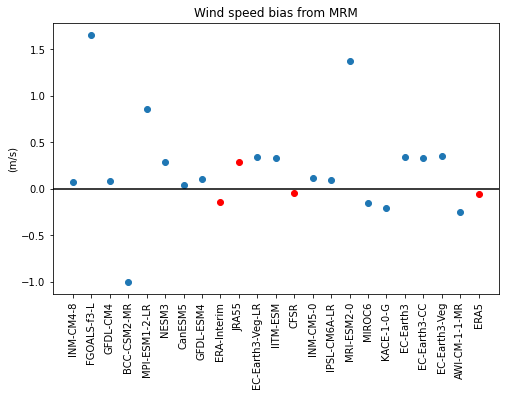

In [55]:
plt.figure(figsize = (8,5))
for k in vl['model']:
    if k not in ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']:
        plt.scatter(wsp_bias.sel(model = k)['model'], wsp_bias.sel(model = k), color = 'C0')
    elif k == 'ERA-Interim':
        plt.scatter(k, wsp_bias_re.sel(model = k), color = 'r')    
    elif k == 'ERA5':
        plt.scatter(k, wsp_bias_re.sel(model = k), color = 'r')       
    elif k == 'CFSR':
        plt.scatter(k, wsp_bias_re.sel(model = k), color = 'r')    
    elif k == 'JRA55':
        plt.scatter(k, wsp_bias_re.sel(model = k), color = 'r')    
#plt.scatter(wsp_bias_re['model'], wsp_bias_re, color = 'r', label = 'Reanalysis')
plt.axhline(y = 0, color =  'k')
plt.xticks(rotation = 90);
plt.title('Wind speed bias from MRM');
plt.ylabel('(m/s)')
plt.savefig('antmargins4.jpg', bbox_inches = 'tight')

In [41]:
uas_ave = {}
for k in keys:
    uas_ave[k] = (uas[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    uas_ave[k] = (uas_cmip[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [42]:
uas_bias = uas_ave[model_keys[0]] - uas_ave['reanalysis']
for k in model_keys[1:]:
    uas_bias = xr.concat([uas_bias, uas_ave[k] - uas_ave['reanalysis']], dim = 'model')
uas_bias['model'] = model_keys

In [43]:
uas_bias_re = uas_ave[keys[0]] - uas_ave['reanalysis']
for k in keys[1:-2]:
    uas_bias_re = xr.concat([uas_bias_re, uas_ave[k] - uas_ave['reanalysis']], dim = 'model')
uas_bias_re['model'] = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']

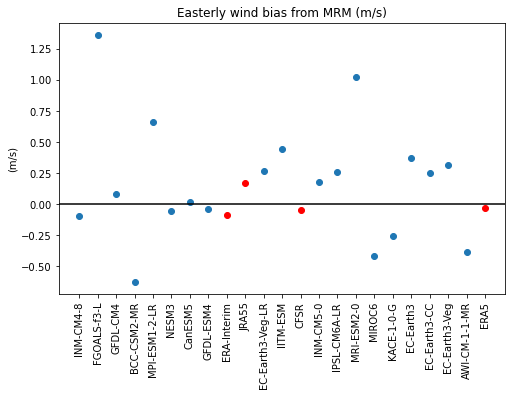

In [53]:
plt.figure(figsize = (8,5))
for k in vl['model']:
    if k not in ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']:
        plt.scatter(uas_bias.sel(model = k)['model'], -uas_bias.sel(model = k), color = 'C0')
    elif k == 'ERA-Interim':
        plt.scatter(k, -uas_bias_re.sel(model = k), color = 'r')    
    elif k == 'ERA5':
        plt.scatter(k, -uas_bias_re.sel(model = k), color = 'r')       
    elif k == 'CFSR':
        plt.scatter(k, -uas_bias_re.sel(model = k), color = 'r')    
    elif k == 'JRA55':
        plt.scatter(k, -uas_bias_re.sel(model = k), color = 'r')    
#plt.scatter(wsp_bias_re['model'], wsp_bias_re, color = 'r', label = 'Reanalysis')
plt.axhline(y = 0, color =  'k')
plt.xticks(rotation = 90);
plt.title('Easterly wind bias from MRM (m/s)');
plt.ylabel('(m/s)')
plt.savefig('antmargins5.jpg', bbox_inches = 'tight')

In [48]:
vas_ave = {}
for k in keys:
    vas_ave[k] = (vas[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    vas_ave[k] = (vas_cmip[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [49]:
vas_bias = vas_ave[model_keys[0]] - vas_ave['reanalysis']
for k in model_keys[1:]:
    vas_bias = xr.concat([vas_bias, vas_ave[k] - vas_ave['reanalysis']], dim = 'model')
vas_bias['model'] = model_keys

In [50]:
vas_bias_re = vas_ave[keys[0]] - vas_ave['reanalysis']
for k in keys[1:-2]:
    vas_bias_re = xr.concat([vas_bias_re, vas_ave[k] - vas_ave['reanalysis']], dim = 'model')
vas_bias_re['model'] = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']

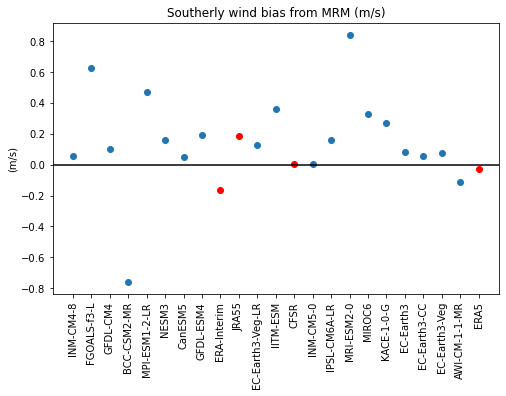

In [54]:
plt.figure(figsize = (8,5))
for k in vl['model']:
    if k not in ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']:
        plt.scatter(vas_bias.sel(model = k)['model'], vas_bias.sel(model = k), color = 'C0')
    elif k == 'ERA-Interim':
        plt.scatter(k, vas_bias_re.sel(model = k), color = 'r')    
    elif k == 'ERA5':
        plt.scatter(k, vas_bias_re.sel(model = k), color = 'r')       
    elif k == 'CFSR':
        plt.scatter(k, vas_bias_re.sel(model = k), color = 'r')    
    elif k == 'JRA55':
        plt.scatter(k, vas_bias_re.sel(model = k), color = 'r')    
#plt.scatter(wsp_bias_re['model'], wsp_bias_re, color = 'r', label = 'Reanalysis')
plt.axhline(y = 0, color =  'k')
plt.xticks(rotation = 90);
plt.title('Southerly wind bias from MRM (m/s)');
plt.ylabel('(m/s)')
plt.savefig('antmargins6.jpg', bbox_inches = 'tight')